### Intensity Transformation Operations on Images

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### Method 1 - Image Negatives


In [2]:
image = cv2.imread('cvdata/im1.jpg')
cv2.imshow('Original Image', image)

w,h= image.shape[:2]
print("Width and Height of image",w,h)

for i in range(w-1):
    for j in range(h-1):
        
        pixel = image[i,j]
        
        pixel[0] = 256 - pixel[0]
        pixel[1] = 256 - pixel[1]
        pixel[2] = 256 - pixel[2]
        
        image[i,j] = pixel
        
cv2.imshow('Image Negative', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Width and Height of image 251 201


#### Method-2 Log Transformations

In [3]:
img = cv2.imread('cvdata/logt.jpg')

image = cv2.resize(img,(0,0),fx=0.4,fy=0.4)

cv2.imshow('Original Image', image)

#To calculate the S or Log transformed first we need to calculate the Scaling Constant C and before 
#that we need the max pixel value of the input image

m = np.max(image)

c = 255 / np.log (1 + m)

Log_Transformed = c*np.log(1+image)

LT = np.array(Log_Transformed,  np.uint8)

cv2.imshow('Log_Transformed', LT)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Method 3 - Power-Law (Gamma) Transformation 

In [4]:
image = cv2.imread('cvdata/gamma.jpg')
img1 = cv2.resize(img,(0,0),fx=0.3,fy=0.3)
cv2.imshow('Original', img1)

gammavals = [0.3,0.7,1.3,2.0]

for i in gammavals:
    gamma = np.array(255*(img1 / 255)**i, dtype = 'uint8' )
    cv2.imshow('Gamma_{}'.format(i), gamma)
    
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Method 4 - Piecewise Linear Transformation

In [5]:
#Defining a function to map the input values with ouput values

r1 = 70
r2 = 140
s1 = 0
s2 = 255

def pixelval(pix, r1,s1,r2,s2):
    if (0 <= pix and pix <= r1):
        return (s1 / r1)*pix
    elif (r1 < pix and pix <= r2):
        return ((s2 - s1)/(r2 - r1)) * (pix - r1) + s1
    else:
        return ((255 - s2)/(255 - r2)) * (pix - r2) + s2
    
img = cv2.imread('cvdata/PLT.jpg')
image = cv2.resize(img,(0,0),fx=.5, fy=.5)

#Vectorizing the fucntion to be applied over all the pixels of input image
pixelval_vec = np.vectorize(pixelval)

#Applying the function to the all pixels of the image
PLT_Output = pixelval_vec(image,r1,s1,r2,s2)

cv2.imshow('Original_Image', image)
cv2.imshow('Piece-Lin_Tranform', PLT_Output)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Image Registration

In [6]:
img1 = cv2.imread('cvdata/IRsample.jpg',0)
imageA = cv2.resize(img1,(0,0), fx=.1 , fy=.1)
img2 = cv2.imread('cvdata/IRref.jpg',0)
imageB = cv2.resize(img2,(0,0), fx=.1 , fy=.1)

cv2.imshow("Subject_img", imageA)
cv2.waitKey(0)
cv2.imshow("Reference_img", imageB)
cv2.waitKey(0)

#Initiate ORB

orb = cv2.ORB_create(7000)

#GETTING THE KEYPOINTS AND DESCRIPTORS

kp1, des1 = orb.detectAndCompute(imageA, None)
kp2, des2 = orb.detectAndCompute(imageB, None)



#Matcher (it just matches the descriptors of one image with the other one)

matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

matches = matcher.match(des1, des2,None)

matches = sorted(matches, key = lambda x:x.distance)


img3 = cv2.drawMatches(imageA, kp1, imageB, kp2,matches[:40] ,None)


points1 = np.zeros((len(matches), 2), dtype = np.float32)
points2 = np.zeros((len(matches), 2), dtype = np.float32)

for i,match in enumerate(matches):
    points1[i,:] = kp1[match.queryIdx].pt
    points2[i,:] = kp2[match.trainIdx].pt

#Homography

h, mask = cv2.findHomography(points1,points2, cv2.RANSAC)

#Using this homography

height, width = imageB.shape[:2]

im1Reg = cv2.warpPerspective(imageA, h, (width, height))

cv2.imshow("Registered_Image", im1Reg)
cv2.waitKey(0)

cv2.destroyAllWindows()




#### Background Subtraction

###### Method 1 : 

In [7]:
cap = cv2.VideoCapture('cvdata/subtract.mp4')

fgbg = cv2.createBackgroundSubtractorMOG2()

while(1):
    ret, frame = cap.read()
    
    fgmask = fgbg.apply(frame)
    cv2.imshow('mask', fgmask)
    cv2.imshow('subtracted_img', frame)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cap.release()   
cv2.destroyAllWindows()

###### Method 2: 

In [8]:
cap = cv2.VideoCapture(0)

ret ,frame = cap.read()

avgvalue = np.float32(frame)

while(1):
    ret,frame = cap.read()
    cv2.accumulateWeighted(frame, avgvalue, 0.06)
    
    resulting_frame = cv2.convertScaleAbs(avgvalue)
    
    
    cv2.imshow('original', frame)
    cv2.imshow('result_Run_Avg', resulting_frame)
    
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    
cap.release()
cv2.destroyAllWindows()

#### Foreground Extraction in an Image using Grabcut Algorithm

Width and Height :  281 500


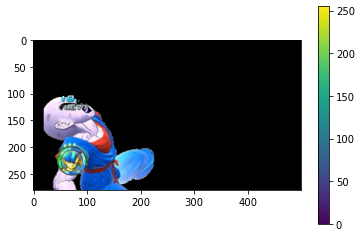

In [40]:
sample = cv2.imread('cvdata/fgsubtract.jpg')
cv2.imshow('Original Image', sample)
cv2.waitKey(0)

w,h = sample.shape[:2]
print("Width and Height : " , w,h)
#Now we need to create a mask similar to the size of the image

mask = np.zeros((w,h) , np.uint8)

#Now creating the Foreground and Background models

foregroundModel = np.zeros((1,65), np.float64)
backgroundModel = np.zeros((1,65), np.float64)

#Creating the rectangle
#Its the ROI where (startingPoint_x, startingPoint_y, width, height) are parameters

rectangle = (20,100,210,420)

#Applying the grabcut method with above parameteres

grabcut = cv2.grabCut(sample,mask,rectangle,backgroundModel,foregroundModel,2,cv2.GC_INIT_WITH_RECT)

#the values of the mask are changed now
mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8')

output = sample*mask2[: ,  :, np.newaxis]

plt.imshow(output)
plt.colorbar()
plt.show()
cv2.destroyAllWindows()